# Checking edges in an image using Prewitt operator and Hough transform
Steps for this method
1. Detecting edges using prewitt operator(Completed ✅)
2. Perform Hough transformation(Completed ✅)

In [2]:
import os
from PIL import Image
from glob import glob

# Open image
images = glob("../../dataset/valid/*.JPG")
export_directory = "../../dataset/invalid/pixelated-dataset/"
if not os.path.isdir(export_directory):
    os.makedirs(export_directory)

In [5]:
print(images[:5])

['../../dataset/valid/N239001014.JPG', '../../dataset/valid/N230201570.JPG', '../../dataset/valid/N230101709.JPG', '../../dataset/valid/N230701220.JPG', '../../dataset/valid/N230301766.JPG']


# Generate pixelated dataset with different levels
starting from 16 till 512 with steps of 16

In [11]:
dim_levels = []
for image in images:
    # Getting individual image
    img = Image.open(image)
    dim_amount = 16
    while dim_amount <= 512:
        imgSmall = img.resize((dim_amount, dim_amount), resample=Image.Resampling.BILINEAR)
        result = imgSmall.resize(img.size, Image.Resampling.NEAREST)
        filename, ext = image.split("/")[-1].split(".")
        directory = f"{export_directory}pixelated-dataset-{dim_amount}"

        # Check whether given directory is exists
        if not os.path.exists(directory):
            os.makedirs(directory)

        result.save(f"{export_directory}pixelated-dataset-{dim_amount}/{filename}-pixelated.{ext}")

        dim_levels.append(dim_amount)
        # Updating the dimension amount
        dim_amount = dim_amount + 128

# Main functions - Prewitt operator and Hough transform

In [3]:
import cv2
import numpy as np
import matplotlib.pylab as plt

def get_horizontal_edges(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Conversion between BGR -> RGB
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Checking for horizontal lines
    kernel_horizontal = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    edges_horizontal = cv2.filter2D(img, -1, kernel_horizontal)

    return edges_horizontal

def get_vertical_edges(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Converstion between BGR -> RGB
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Checking for vertical lines
    kernel_vertical = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    edges_vertical = cv2.filter2D(img, -1, kernel_vertical)

    return edges_vertical

def get_vertical_and_horizontal_edges(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Horizontal and vertical images filters
    kernel_horizontal = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    kernel_vertical = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

    edges_horizontal = cv2.filter2D(img, -1, kernel_horizontal)
    edges_vertical = cv2.filter2D(img, -1, kernel_vertical)

    return edges_horizontal + edges_vertical

In [48]:
import cv2
import math

def get_lines(img):
    horizontal_count, vertical_count = 0, 0
    img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lines = cv2.HoughLines(img, 1, np.pi / 180, 50, None, 50, 10)

    # Generating image with only horizontal and vertical lines
    for lin_index in range(len(lines)):
        p = lines[lin_index][0]
        dis, angle = p[0], p[1]

        height, width = img.shape

        # Accpeting only horizontal and vertical lines
        if angle == 0:
            # Given lines is a horizontal line
            horizontal_count += 1
        elif 1.56 <=  angle <= 1.58:
            # Given line is a vertical line
            vertical_count += 1
        else:
            continue

        a = math.cos(angle)
        b = math.sin(angle)

        x0 = a * dis
        y0 = b * dis

        pt1 = (int(x0 + 413*(-b)), int(y0 + 531*(a)))
        pt2 = (int(x0 - 413*(-b)), int(y0 - 531*(a)))

        cv2.line(img_color, pt1, pt2, (255, 0, 0), 2, cv2.LINE_AA)

    return [img_color, vertical_count, horizontal_count]


# ICAO14 Calculation

In [5]:
import matplotlib.pyplot as plt


def get_icao14(image_path, show=False):
    edges_img = get_vertical_and_horizontal_edges(image_path)
    [lines_img, vertical_count, horizontal_count] = get_lines(edges_img)

    # Showing the results if necessary
    if show:
        plt.subplot(1, 2, 1)
        plt.imshow(edges_img, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.imshow(lines_img)

    # Calculation icao14 -> Inverse propational of horizontal and vertical edges
    return [1 / (horizontal_count + vertical_count), horizontal_count, vertical_count]

## Test for an image

In [ ]:
image_path = "./images/Passport-Image-[2].jpg"
# image_path = "./images/dataset/N230102012.JPG"

print(get_icao14(image_path, show=True))

# Generating ICAO14 values for whole dataset

In [27]:
import csv
from glob import glob
from itertools import product

images = glob("./images/dataset/*.JPG")[:100]
pixelations = [dim for dim in range(16, 513, 16)]

# Writing to the csv file
csv_file = open("icao12-results.csv", "w")
current_count = 1

tot_images = product(images, pixelations)
total_count = len(images) * len(pixelations)


for image, dim in tot_images:
    image = image.split("\\")[-1]
    image_path = f"./images/pixelated-dataset-{dim}/{image.split('.')[0]}-pixelated.{image.split('.')[-1]}"


    [icao14, horizontal_count, vertical_count] = get_icao14(image_path, show=False)
    csv_file.writelines("{},{},{},{},{}\n".format(image, dim, horizontal_count, vertical_count, icao14))

    current_count += 1
    print(f"{image} - {dim} - {current_count/total_count * 100}%")

csv_file.close()


N230101660.JPG - 16 - 0.0625%
N230101660.JPG - 32 - 0.09375%
N230101660.JPG - 48 - 0.125%
N230101660.JPG - 64 - 0.15625%
N230101660.JPG - 80 - 0.1875%
N230101660.JPG - 96 - 0.21875000000000003%
N230101660.JPG - 112 - 0.25%
N230101660.JPG - 128 - 0.28125%
N230101660.JPG - 144 - 0.3125%
N230101660.JPG - 160 - 0.34375%
N230101660.JPG - 176 - 0.375%
N230101660.JPG - 192 - 0.40625%
N230101660.JPG - 208 - 0.43750000000000006%
N230101660.JPG - 224 - 0.46875%
N230101660.JPG - 240 - 0.5%
N230101660.JPG - 256 - 0.53125%
N230101660.JPG - 272 - 0.5625%
N230101660.JPG - 288 - 0.59375%
N230101660.JPG - 304 - 0.625%
N230101660.JPG - 320 - 0.65625%
N230101660.JPG - 336 - 0.6875%
N230101660.JPG - 352 - 0.71875%
N230101660.JPG - 368 - 0.75%
N230101660.JPG - 384 - 0.78125%
N230101660.JPG - 400 - 0.8125%
N230101660.JPG - 416 - 0.84375%
N230101660.JPG - 432 - 0.8750000000000001%
N230101660.JPG - 448 - 0.9062499999999999%
N230101660.JPG - 464 - 0.9375%
N230101660.JPG - 480 - 0.96875%
N230101660.JPG - 496 - 

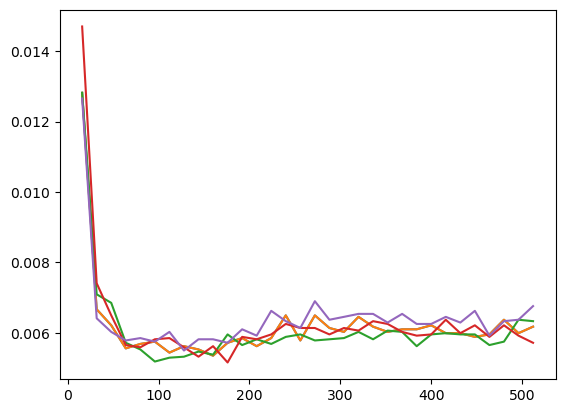

In [28]:
# Plotting the graphs for icao14 values
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

image_names = ["N230101899.JPG", "N230101899.JPG", "N230101959.JPG", "N230101841.JPG", "N230101780.JPG"]

def generate_plot(image_name):
    myData = genfromtxt("icao12-results.csv", dtype=str, delimiter=",")

    elements = []
    for element in myData:
        if element[0] == image_name: elements.append(element)

    xValues, yValues = [], []
    for element in elements:
        xValues.append(int(element[1]))
        yValues.append(float(element[-1]))

    plt.plot(xValues, yValues, '-')

for image in image_names:
    generate_plot(image)

# Evaluation

Calculations for the evaluation of the results,
    - With execution of above code, we get the csv file with the results of the icao14 values for each image and each pixelation.
    - With execution of pre-run code, we get the csv file with the results of the icao14 values for each image and each pixelation.

<br>
<br>

## Calculations

In [24]:
pixlated_dirs = glob(export_directory+"*", recursive=True)
print(pixlated_dirs)

['../../dataset/invalid/pixelated-dataset/pixelated-dataset-256', '../../dataset/invalid/pixelated-dataset/pixelated-dataset-416', '../../dataset/invalid/pixelated-dataset/pixelated-dataset-512']


../../dataset/invalid/pixelated-dataset/pixelated-dataset-256


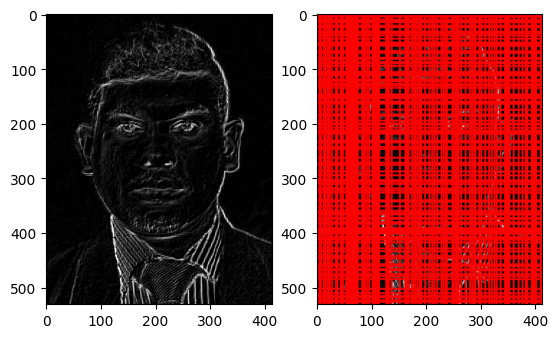

In [37]:
# pixlated_dirs = glob(export_directory+"*", recursive=True)
values = {}

for pixlated_dir in pixlated_dirs:
    pixlated_images = glob(pixlated_dir+"/*.JPG")
    print(pixlated_dir)
    dim = pixlated_dir.split('-')[-1]
    values[str(dim)] = []

    for pixlated_image in pixlated_images:
        [icao14, horizontal_count, vertical_count] = get_icao14(pixlated_image, show=False)

        values[dim].append(icao14)

In [51]:
print(values.keys())

dict_keys(['256'])


## Plotting the graphs

### With execution of above code

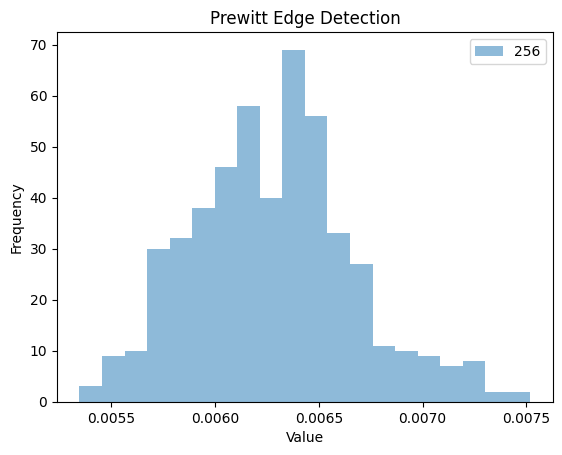

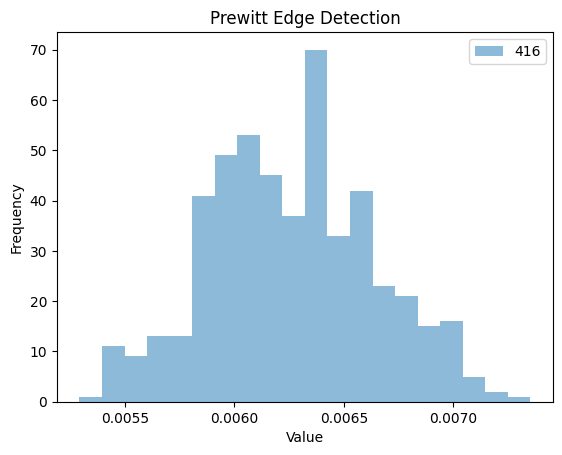

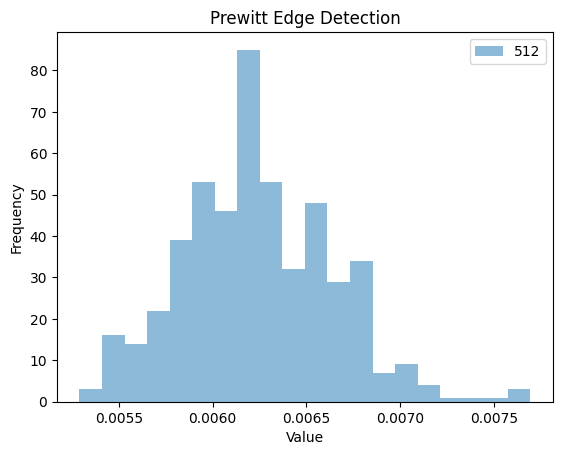

In [35]:
import matplotlib.pyplot as plt

# Create a figure and axis

# Plot the histograms
n_bins = 20  # Number of bins in the histogram
for dim, vals in values.items():
    fig, ax = plt.subplots()
    ax.hist(vals, bins=n_bins, alpha=0.5, label=dim)

    # Add labels and title
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title('Prewitt Edge Detection')

    # Add legend
    ax.legend()
    plt.savefig(f'prewitt_edge_detection-dim{dim}.png')

    # Show the plot
    plt.show()


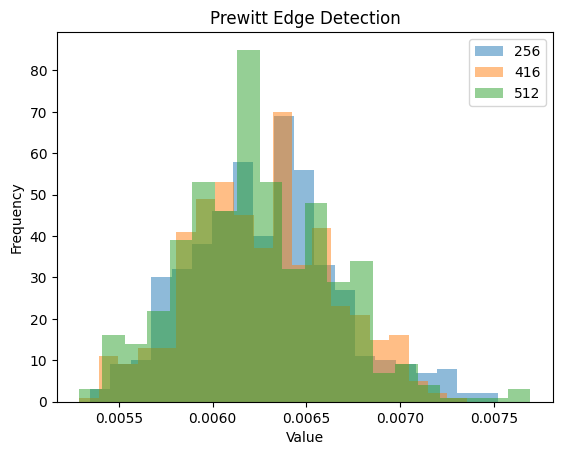

In [34]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the histograms
n_bins = 20  # Number of bins in the histogram
for dim, vals in values.items():
    ax.hist(vals, bins=n_bins, alpha=0.5, label=dim)

# Add labels and title
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Prewitt Edge Detection')

# Add legend
ax.legend()
plt.savefig('prewitt_edge_detection.png')

# Show the plot
plt.show()


### With execution of pre-run code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

csv_file = '../../detectors/pixelation/icao12-results.csv'
df = pd.read_csv(csv_file)



In [3]:
df.columns = ['image', 'dim', 'horizontal_count', 'vertical_count', 'icao14']
df.head()

,image,dim,horizontal_count,vertical_count,icao14
0,N230101660.JPG,32,75,79,0.006494
1,N230101660.JPG,48,79,82,0.006211
2,N230101660.JPG,64,83,100,0.005464
3,N230101660.JPG,80,89,93,0.005495
4,N230101660.JPG,96,88,98,0.005376


array([[<Axes: title={'center': '16'}>, <Axes: title={'center': '32'}>,
        <Axes: title={'center': '48'}>, <Axes: title={'center': '64'}>,
        <Axes: title={'center': '80'}>, <Axes: title={'center': '96'}>],
       [<Axes: title={'center': '112'}>, <Axes: title={'center': '128'}>,
        <Axes: title={'center': '144'}>, <Axes: title={'center': '160'}>,
        <Axes: title={'center': '176'}>, <Axes: title={'center': '192'}>],
       [<Axes: title={'center': '208'}>, <Axes: title={'center': '224'}>,
        <Axes: title={'center': '240'}>, <Axes: title={'center': '256'}>,
        <Axes: title={'center': '272'}>, <Axes: title={'center': '288'}>],
       [<Axes: title={'center': '304'}>, <Axes: title={'center': '320'}>,
        <Axes: title={'center': '336'}>, <Axes: title={'center': '352'}>,
        <Axes: title={'center': '368'}>, <Axes: title={'center': '384'}>],
       [<Axes: title={'center': '400'}>, <Axes: title={'center': '416'}>,
        <Axes: title={'center': '432'}>,

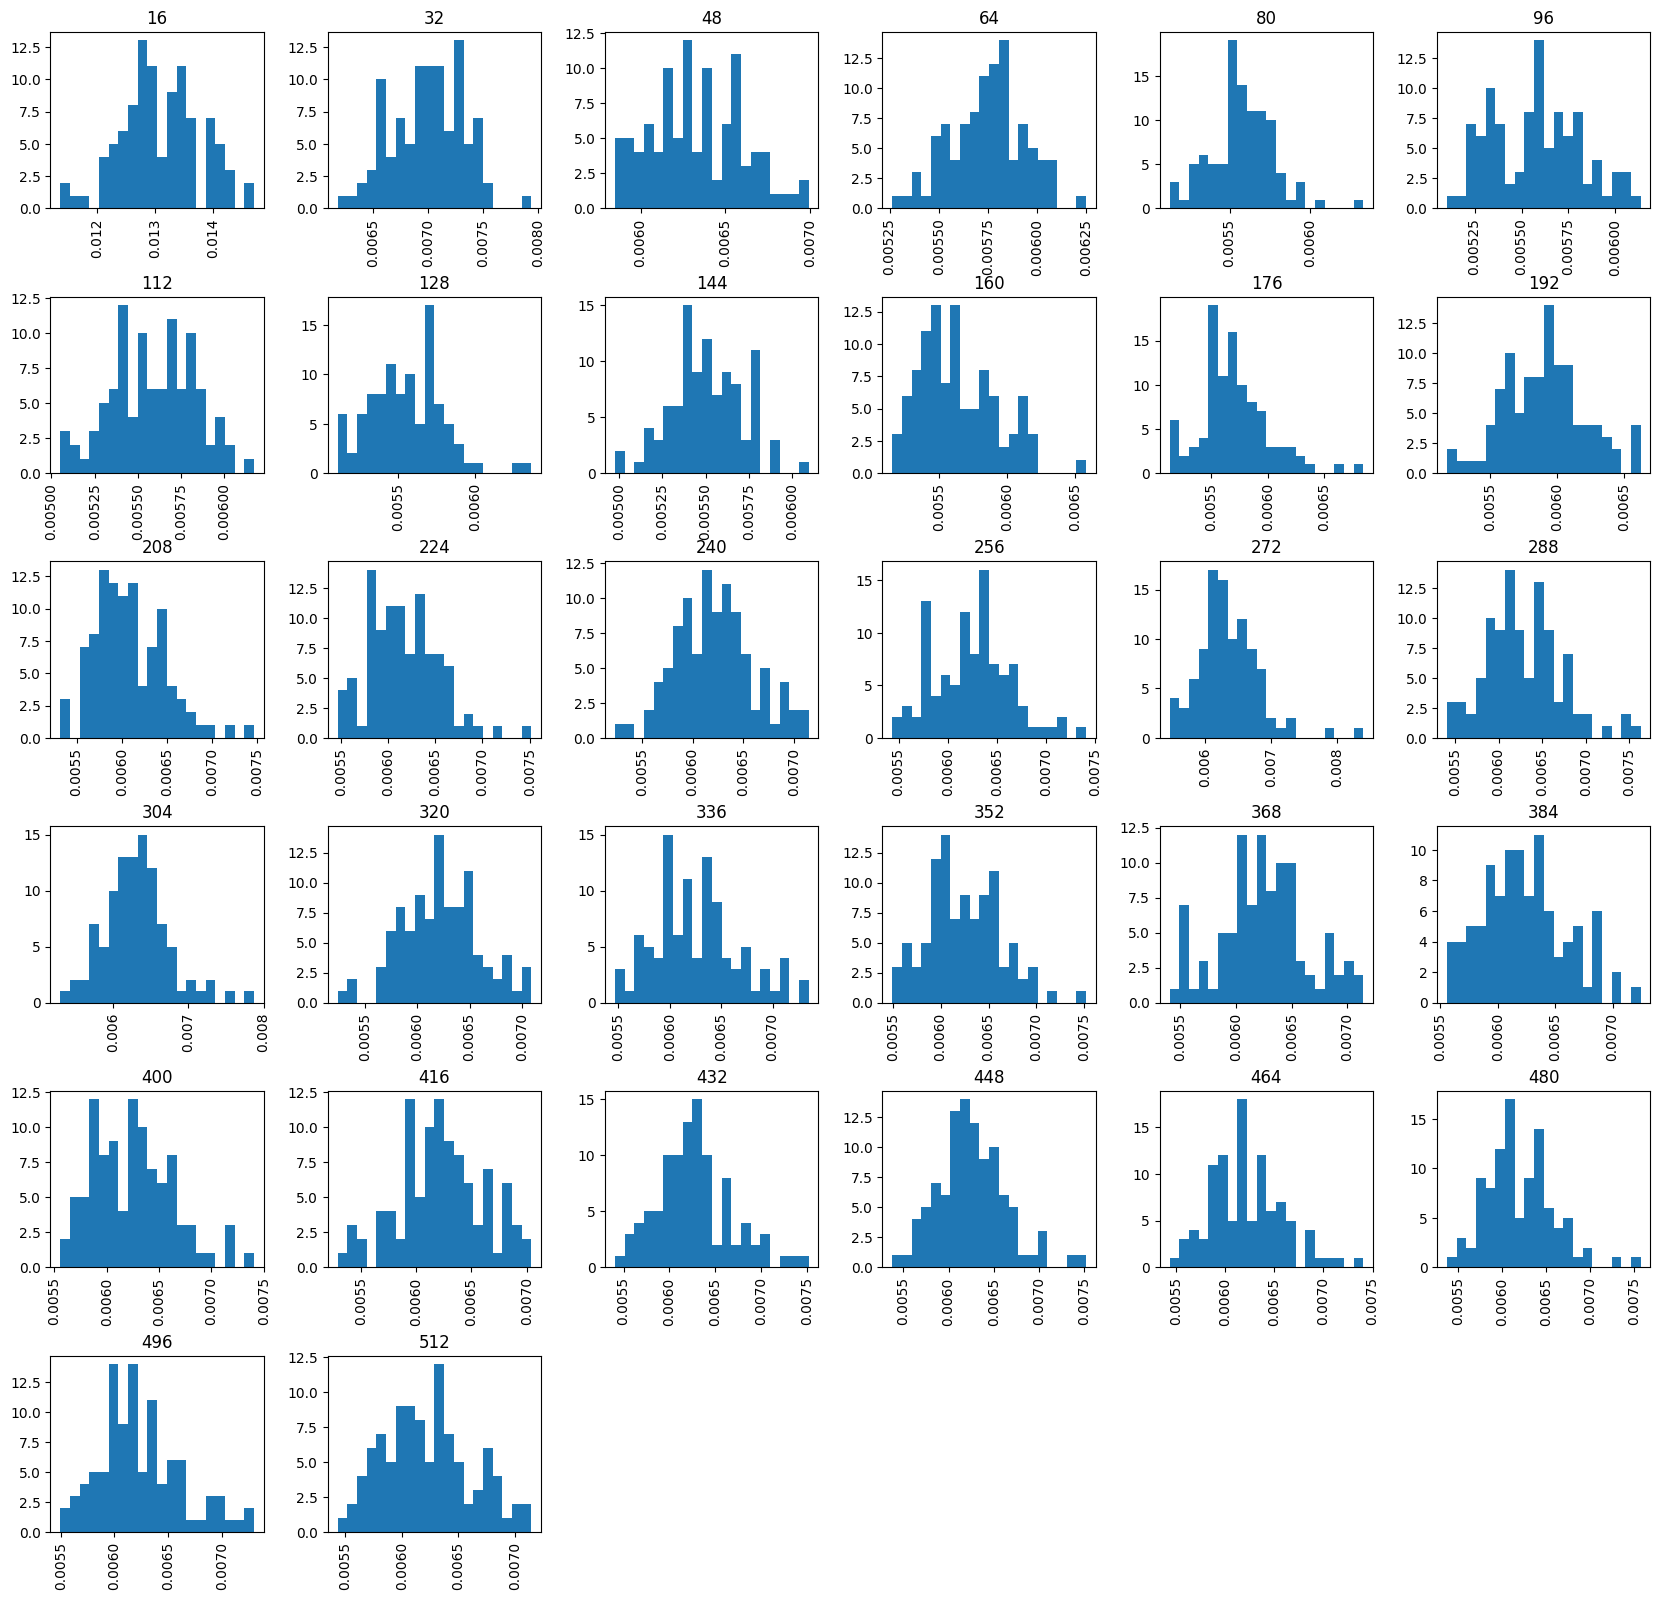

In [4]:
df['icao14'].hist(by=df['dim'], bins=20, figsize=(20, 20))

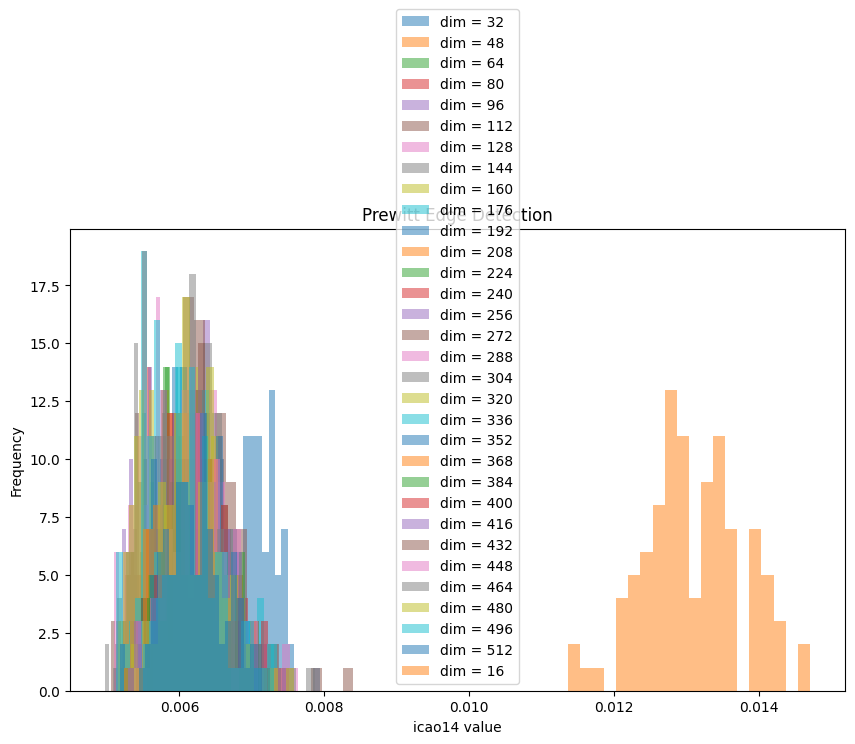

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary to hold histograms for each unique 'dim' value
histograms = {}
for dim_value in df['dim'].unique():
    histograms[dim_value] = df[df['dim'] == dim_value]['icao14']

# Plot overlapping histograms
plt.figure(figsize=(10, 6))
for dim_value, histogram_data in histograms.items():
    plt.hist(histogram_data, bins=20, alpha=0.5, label=f'dim = {dim_value}')

plt.xlabel('icao14 value')
plt.ylabel('Frequency')
plt.title('Prewitt Edge Detection')
plt.legend()
plt.show()
